# Hierarchical Bayesian Modelling in Real life

This notebook was created for PyData NYC 2018.  

### Import all necessary libraries

In [1]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
import seaborn as sns
from theano import shared

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Background

## Campaign spend data

This data comes from 13K digital marketing campaigns that were run since 2016.  Besides business ID, we have a set of variables that will be important to the model.  

billed_amount : The amount billed for the campaign.  This is based on real data, but is not itself real.  Privacy issues and all that.

log_billed_amount : The log of billed_amount.  Typically, spend amounts are log-normally distributed.  There's a small number of high spenders, and a large number of low spenders.

product : The products we'll be focused on. They are as follows:
    - Display = Display advertising, like you might see on a website
    - SEM = Search Engine Marketing, dealing with "sponsored" search results in Google and Bing
    - SEO = Search Engine Optimization, general name for services that aim to increase "organic" traffic, or traffic outside of paid services
    - Social = Advertising on social networks, specifically Facebook and Instagram
    - Email = Direct email advertising, like you might get in your inbox.
    
size : Size of the company.  We have grouped this into four categories: Less than 50 employees, between 50 and 100,  more than 100 and "unavailable".  Unavailable just means we were unable to capture this information.

region : The high-level US region of the company headquarters: Northeast, South, Midwest or West.

In [2]:
# reading in data
campaign_data = pd.read_csv('spend_data_distribute.csv')

### Initial descriptives
We run these just so we have a sense of what our data looks like.  For this tutorial, we will be focusing on Product and Region, so we'll pay close attention to that.

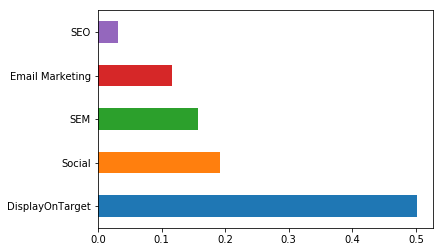

In [3]:
campaign_data['product'].value_counts(normalize=True).plot(kind='barh')

In [4]:
# drop those without industry
campaign_data = campaign_data[campaign_data.industry!='unavailable']
campaign_data.shape

(13092, 11)

In [5]:
campaign_data = campaign_data.sample(frac=.3)

## Constructing the models in PyMC3
Now we get into the fun part.  We'll be constructing 3 models here:

1) Pooled model: This is the non-hierarchical approach.  We estimate a single $\alpha$ and a single $\beta$ for each feature.  For the $\alpha$ to have meaning, we'll need to include a reference category with each of our features.  The easiest way to do this is to just one-hot encode the features.  In math:



2) Product-level $\alpha$: This is where we start getting hierarchical.  In this model, we replace our $\alpha$ with $\alpha_p$ for p in {SEO, Email Marketing, SEM, Social, DisplayOnTarget}.  Essentially, a product-level intercept.  These product-level intercepts are drawn from the same distribution with their own set of hyperpriors. 



3) Product and region-level $\alpha$: Now we also add another group-level $\alpha$, $\alpha_r$ for r in {Northeast, South, Midwest, West}.  We have both product-level and region-level intercepts.  Region-level intercept is drawn from its own distribution, which is separate from both the $\beta$'s distribution and $\alpha_p$'s distribution.




In [6]:
# for pooled: need dummy variables
dummy_dict = {}
for c in ['product', 'size', 'region', 'industry']:
    dummy_dict[c] = pd.get_dummies(campaign_data[c]).iloc[:,1:]

In [14]:
model_dict

{'pooled': <pymc3.model.Model at 0x11047dda0>,
 'product_alphas': <pymc3.model.Model at 0x12239bf60>,
 'product_region_alphas': <pymc3.model.Model at 0x139dc4940>}

In [18]:
pm.compare({model_dict['pooled']:trace_dict['pooled'], 
            model_dict['product_alphas']:trace_dict['product_alphas'],
           model_dict['product_region_alphas']:trace_dict['product_region_alphas']})

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,9804.94,22.88,0,0.53,107.36,0,0
1,9805.14,21.94,0.19,0.42,107.43,1.54,0
0,9813.6,30.65,8.66,0.05,107.45,5.96,0


In [8]:
def run_model(model, m_name, trace_num=5000, tune=1000):
    # utility function for running model, displaying traceplots and diagnostics
    with model:
        trace = pm.sample(trace_num, tune=tune)[tune:]
    pm.plots.traceplot(trace)
    print("\nWAIC: {}".format(pm.stats.waic(trace, model=model)))
    return(trace)

In [9]:
model_dict = {}
# non-hierarchical / pooled
with pm.Model() as model:
    product_betas = pm.Normal('product_betas', mu=0., sd=1.0, 
                              shape=campaign_data['product'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=0., sd=1.0, 
                           shape=campaign_data['size'].nunique()-1)
    region_betas = pm.Normal('region_betas', mu=0., sd=1.0,
                             shape=campaign_data['region'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=0., sd=1.0,
                               shape=campaign_data['industry'].nunique()-1)
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(product_betas, dummy_dict['product'].values.T)+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(region_betas, dummy_dict['region'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['pooled'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, industry_betas, region_betas, size_betas, product_betas]
Sampling 2 chains: 100%|██████████| 8000/8000 [04:21<00:00, 30.57draws/s]
The number of effective samples is smaller than 10% for some parameters.



WAIC: WAIC_r(WAIC=9813.5999478833692, WAIC_se=107.44670516813586, p_WAIC=30.649651406115641, var_warn=0)


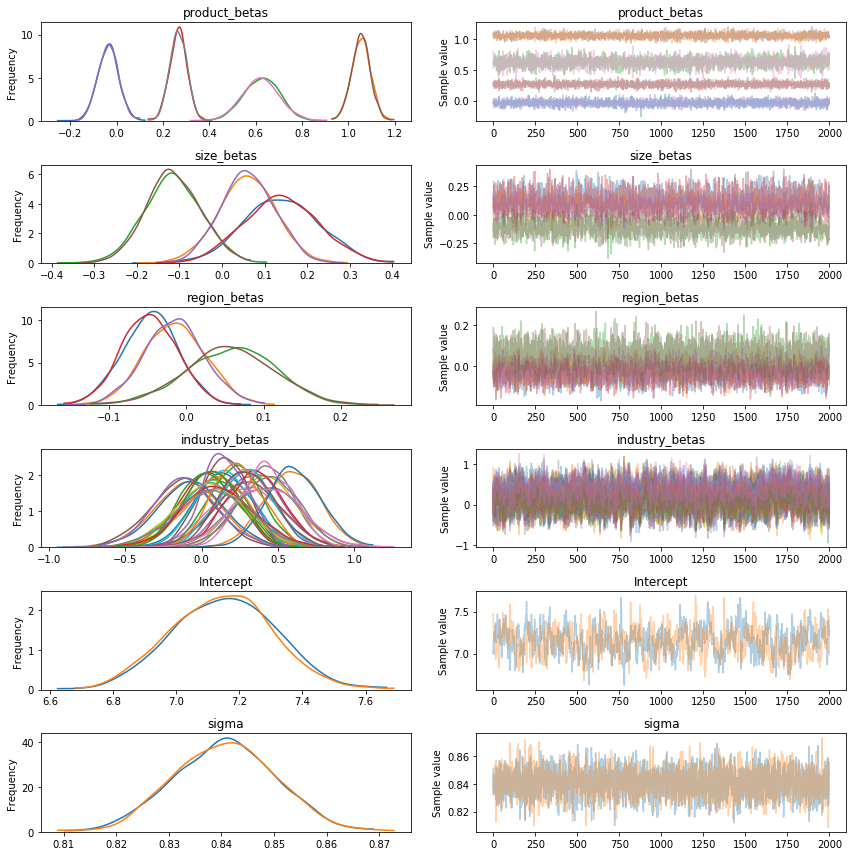

In [10]:
trace_dict = {}
trace_dict['pooled'] = run_model(model_dict['pooled'], 'pooled', trace_num=3000, tune=1000)

### Interpreting PyMC3's traceplots
Let's break here to take a look at exactly what we're seeing in the plots above.

On the right, we're seeing the results of the No U-Turn sampler PyMC3 automatically assigned to our parameters.  As you remember, a sampler draws from the posterior distribution by only "accepting" a value if it increases the likelihood of the data.  You can see the movement of that sampler (i.e. the "trace") in these plots.  Typically, a good trace will fully explore the probability space and not get stuck in certain areas.  For more information on how to escape these narrowed traces, [read more at Thomas Wiecki's blog](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered).

On the left you see our posterior distribution.  We've enforced normal priors here, so it's to be expected that we're seeing a normal distribution returned.  The doubling of the lines you're seeing are from different sampler runs (i.e. "chains").  It's good practice to check that the two chains don't differ much from one another.

So now let's press ahead with the hiearchical formulations:

In [11]:
# hiearchical - product
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # product-level intercept
    product_alphas = pm.Normal('product_alphas', mu=mu_a, sd=sigma_a, 
                              shape=campaign_data['product'].nunique())
    
    # betas
    region_betas = pm.Normal('region_betas', mu=mu_b, sd=sigma_b,
                             shape=campaign_data['region'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[campaign_data['product_idx'].values]+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(region_betas, dummy_dict['region'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_alphas'] = model

In [12]:
# hiearchical - product and region
with pm.Model() as model:
    # Hyperpriors
    mu_a_product = pm.Normal('mu_a_product', mu=0., sd=1)
    sigma_a_product = pm.HalfCauchy('sigma_a_product', beta=1)
    mu_a_region = pm.Normal('mu_a_region', mu=0., sd=1)
    sigma_a_region = pm.HalfCauchy('sigma_a_region', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)    
    
    # product and region-level intercepts
    product_alphas = pm.Normal('product_alphas', mu=mu_a_product, sd=sigma_a_product, 
                              shape=campaign_data['product'].nunique())
    region_alphas = pm.Normal('region_alphas', mu=mu_a_region, sd=sigma_a_region,
                         shape=campaign_data['region'].nunique())
    
    # betas
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[campaign_data['product_idx'].values]+\
        region_alphas[campaign_data['region_idx'].values]+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_region_alphas'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, industry_betas, size_betas, region_betas, product_alphas, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [03:11<00:00, 41.88draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...



WAIC: WAIC_r(WAIC=9805.1361287584768, WAIC_se=107.43490780489878, p_WAIC=21.941674730574693, var_warn=0)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, industry_betas, size_betas, region_alphas, product_alphas, sigma_beta, mu_beta, sigma_a_region, mu_a_region, sigma_a_product, mu_a_product]
Sampling 2 chains: 100%|██████████| 8000/8000 [25:10<00:00,  5.29draws/s]  
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
There were 510 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.716653742961, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.



WAIC: WAIC_r(WAIC=9804.944235763327, WAIC_se=107.35642350626567, p_WAIC=22.88435500181324, var_warn=0)


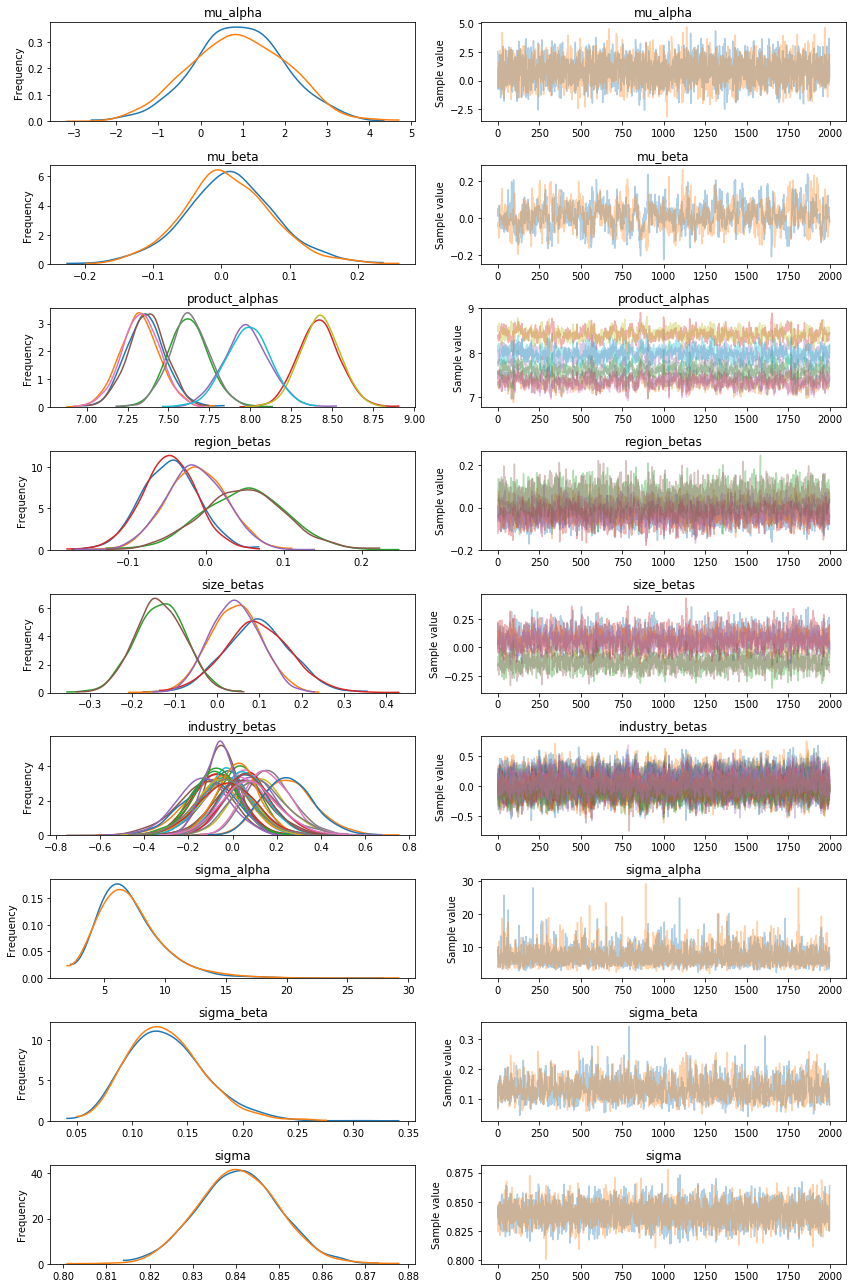

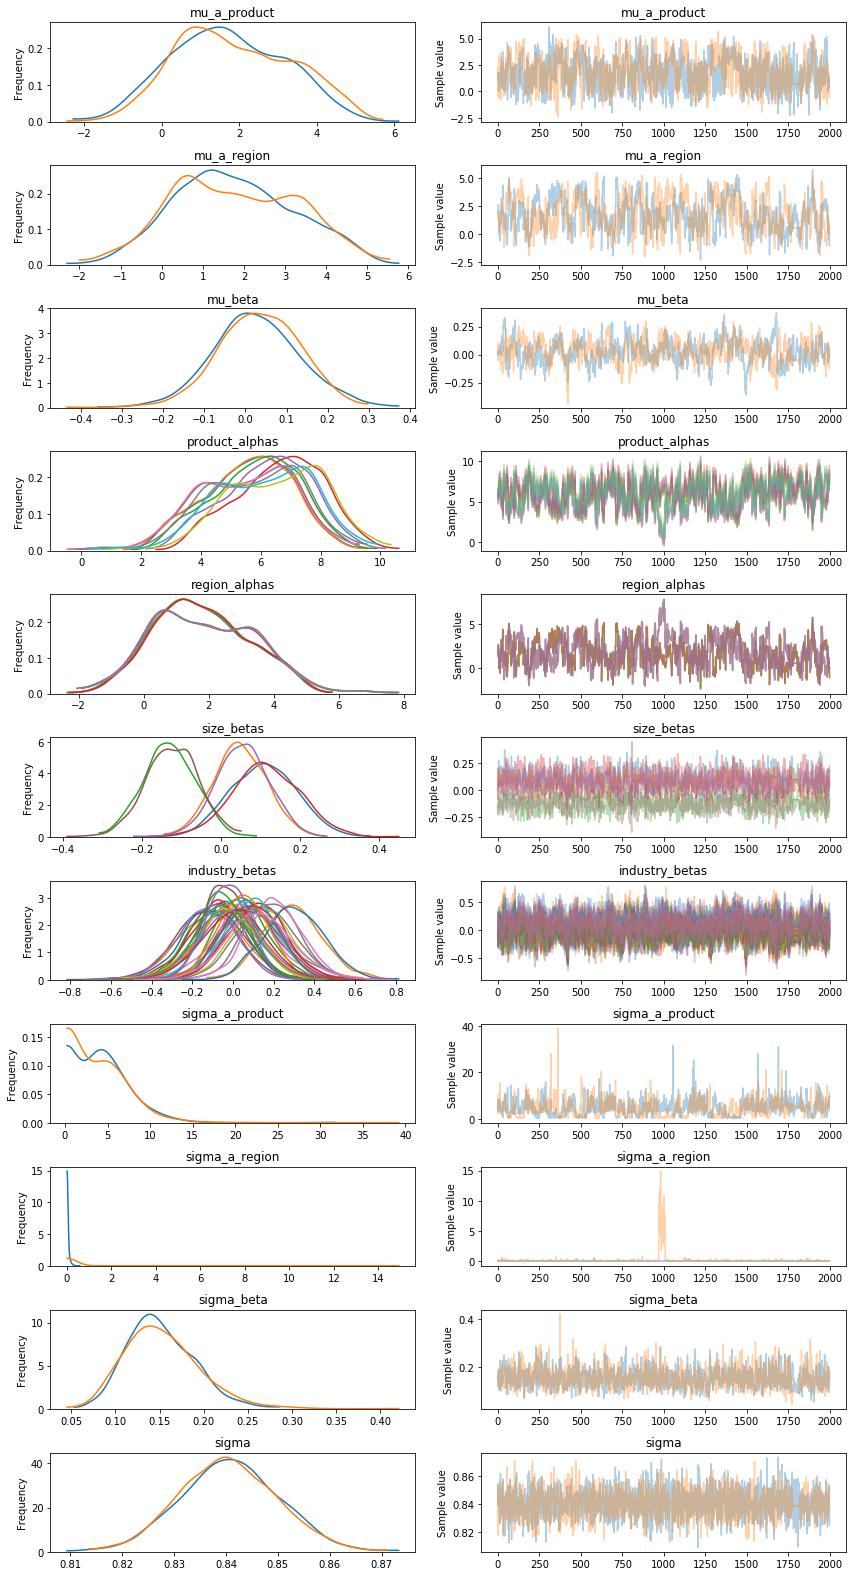

In [13]:
for m in ['product_alphas', 'product_region_alphas']:
    trace_dict[m] = run_model(model_dict[m], m, trace_num=3000, tune=1000)

### Evaluating hierarchical traceplots
- Are there any issues when we finally do this full run
- Can we diagnose and treat those issues?
- Overall, it doesn't seem like having individual alphas for regions are particularly useful
- Probably makese sense to press forward with product-level

### Posterior Predictive Checks
- Define - go to slides
- Look at the posterior predictive distribution for different products, versus the product actual
- Some kind of bayesian-type evaluation metric
- Seems like we have an okay model

### 

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()
channel = 'SEM'

label_dict = {'base':'pooled', 'ch_fe': 'product', 'ch_reg_fe': 'product+region'}

for m in ['base', 'ch_fe', 'ch_reg_fe']:
    print(m)
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    if m == 'ch_separate':
        pred_y = ppc_dict[m][0]
    else:
        pred_y = ppc_dict[m][0][(X_sample.product_family==channel).values]
    if m in label_dict:
        sns.kdeplot(pred_y, ax=ax, label=label_dict[m])
    else:
        sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample[X_sample.product_family==channel]['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')
ax.set_xlabel('log spend')
ax.set_title('Predicted ranges vs actual')

In [ ]:
waics_dict = {}
for k in trace_dict:
    print(k)
    waics_dict[k] = pm.waic(trace_dict[k], model_dict[k])
    print(waics_dict[k])
    

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()

for m in model_dict:
    print m
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    pred_y = ppc_dict[m][10]
    sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')

In [ ]:
# Changing values here will also change values in the model
predictors.set_value(X[model_feats].iloc[:100].values.T)